# Analysis of test set human predictions. 3 human reviewers labeled all videos in the test set, for every 10 seconds of each video, for audio, video, and audio+video inputs.

In [3]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
import os
import numpy as np
import networkx as nx
from sklearn.metrics import cohen_kappa_score

In [2]:
# Humans make predictions every 10 seconds on test set.
INTERVAL = 10

In [4]:
# Load information about each video
video_info = pd.read_csv('/datasets/cgn/EGOCOM/video_info.csv')
print('Total hours of video in EgoCom dataset: {:.1f}'.format(
    np.sum(video_info['duration_seconds']) / 3600))

Total hours of video in EgoCom dataset: 38.5


In [4]:
pd.read_csv('/datasets/cgn/EGOCOM/ground_truth_transcriptions.csv').head()

,conversation_id,endTime,speaker_id,startTime,word
0,day_1__con_1__part1,0.43,1,0.09,Okay
1,day_1__con_1__part1,0.43,1,0.09,.
2,day_1__con_1__part1,NaN,1,NaN,
3,day_1__con_1__part1,0.92,1,0.76,So
4,day_1__con_1__part1,0.92,1,0.76,","


In [12]:
# Load ground truth labels. This takes a few minutes.
data_dir = "/datasets/cgn/EGOCOM/human_predictions/"
egocom_loc = "/datasets/cgn/EGOCOM/egocom_features/no_audio/"
cols = ['video_id', 'clip_id', 'video_speaker_id', 'is_speaking', 'multiclass_speaker_label']
egocom_features = pd.read_csv(egocom_loc + "egocom_features_history_10sec.csv.gz")[cols]

### Notes about 'egocom_features_history_NNsec.csv.gz' files. the clip_id is not a universal id across files. The clip_id starts at 00:10 for the 10sec history and 00:05 for 5sec history and so forth.

### So for 'egocom_features_history_10sec.csv.gz':
* clip_id = 0 refers to the 1 second clip from 00:10-00:11
* clip_id = 1 refers to the 1 second clip from 00:11-00:12
* clip_id = 2 refers to the 1 second clip from 00:12-00:13
* and so forth...

### And for 'egocom_features_history_5sec.csv.gz':
* clip_id = 0 refers to the 1 second clip from 00:05-00:06
* clip_id = 1 refers to the 1 second clip from 00:06-00:07
* clip_id = 2 refers to the 1 second clip from 00:07-00:08
* and so forth...

# compute baselines

In [404]:
from sklearn.metrics import confusion_matrix

print('Test set\n--------\n')

print("Baselines for anyone speaking")
test_set_is_speaking = egocom_features[
    egocom_features.video_id.isin(video_info[video_info['test']].video_id)
]['is_speaking']

print('Baseline prob(not speaking):', round((len(test_set_is_speaking) - sum(test_set_is_speaking)) / len(test_set_is_speaking), 2))

for future in [1, 5, 10]:
    # We can compute the prob(speaking in future | speaking now) in two ways
    # Method 1
    cmat = confusion_matrix(
        test_set_is_speaking[:-future], test_set_is_speaking[future:])
    conditional_prob = cmat[0][0] / (cmat[0][1] + cmat[0][0])
    # Method 2
    conditional_prob2 = sum((test_set_is_speaking[:-future].values == 0) &\
                      (test_set_is_speaking[future:].values == 0)) /\
          sum(test_set_is_speaking[:-future].values == 0)
    assert(conditional_prob == conditional_prob2)
    print('Future:', future, 'second(s)\t| prob(not speaking in future | not speaking now):', 
          round(conditional_prob, 2))
    
for future in [1, 5, 10]:
    # We can compute the prob(speaking in future | speaking now) in two ways
    # Method 1
    cmat = confusion_matrix(
        test_set_is_speaking[:-future], test_set_is_speaking[future:])
    conditional_prob = cmat[1][1] / (cmat[1][0] + cmat[1][1])
    # Method 2
    conditional_prob2 = sum((test_set_is_speaking[:-future].values == 1) &\
                      (test_set_is_speaking[future:].values == 1)) /\
          sum(test_set_is_speaking[:-future].values == 1)
    assert(conditional_prob == conditional_prob2)
    print('Future:', future, 'second(s)\t| prob(speaking in future | speaking now):', 
          round(conditional_prob, 2))
    
for future in [1, 5, 10]:
    cmat = confusion_matrix(
        test_set_is_speaking[:-future], test_set_is_speaking[future:])
    conditional_prob = (cmat[0][0] + cmat[1][1]) / sum(sum(cmat))
    print('Future:', future, 'second(s)\t| prob(same, i.e. still speaking or not):', 
          round(conditional_prob, 2))
    
    
print("\nBaselines for host speaking")
test_set_host_is_speaking = egocom_features[
    egocom_features.video_id.isin(video_info[video_info['test'] & video_info['speaker_is_host']].video_id)
]['is_speaking']

for future in [1, 5, 10]:
    # We can compute the prob(speaking in future | speaking now) in two ways
    # Method 1
    cmat = confusion_matrix(
        test_set_host_is_speaking[:-future], test_set_host_is_speaking[future:])
    conditional_prob = cmat[0][0] / (cmat[0][1] + cmat[0][0])
    # Method 2
    conditional_prob2 = sum((test_set_host_is_speaking[:-future].values == 0) &\
                      (test_set_host_is_speaking[future:].values == 0)) /\
          sum(test_set_host_is_speaking[:-future].values == 0)
    assert(conditional_prob == conditional_prob2)
    print('Future:', future, 'second(s)\t| prob(host not speaking in future | host not speaking now):', 
          round(conditional_prob, 2))
    
for future in [1, 5, 10]:
    # We can compute the prob(speaking in future | speaking now) in two ways
    # Method 1
    cmat = confusion_matrix(
        test_set_host_is_speaking[:-future], test_set_host_is_speaking[future:])
    conditional_prob = cmat[1][1] / (cmat[1][0] + cmat[1][1])
    # Method 2
    conditional_prob2 = sum((test_set_host_is_speaking[:-future].values == 1) &\
                      (test_set_host_is_speaking[future:].values == 1)) /\
          sum(test_set_host_is_speaking[:-future].values == 1)
    assert(conditional_prob == conditional_prob2)
    print('Future:', future, 'second(s)\t| prob(host speaking in future | host speaking now):', 
          round(conditional_prob, 2))
    
for future in [1, 5, 10]:
    cmat = confusion_matrix(
        test_set_host_is_speaking[:-future], test_set_host_is_speaking[future:])
    conditional_prob = (cmat[0][0] + cmat[1][1]) / sum(sum(cmat))
    print('Future:', future, 'second(s)\t| prob(host still speaking or not):', 
          round(conditional_prob, 2))    


print("\nBaselines for multi-speaker")
test_set_label = egocom_features[
    egocom_features.video_id.isin(video_info[video_info['test']].video_id)
]['multiclass_speaker_label']
    
for future in [1, 5, 10]:
    conditional_prob = sum(test_set_label[:-future].values == test_set_label[future:].values) / len(test_set_label)
    print('Future:', future, 'second(s)\t| prob(same person is speaking):', 
          round(conditional_prob, 2))

# create map that relabels participants 2 and 3 to 2 (non-host),
# 1 to 1 (host), and 0 to 0 (no one is peaking)
map32 = {-1:0, 0:0, 1:1, 2:2, 3:2}
fontsize = 24
labels = {0: 'No speech', 1: 'Host', 2: 'Participants*',}
# Compute multi-speaker transition matrix
for future in [1, 5, 10]:
    cmat = confusion_matrix(
        test_set_label[:-future].map(map32),  # now (rows)
        test_set_label[future:].map(map32),  # future (columns)
    )
    conditional_matrix = (cmat.T / cmat.sum(axis=1)).T
    print('Future:', future, 'second(s)\t| prob(same person is speaking):\n', conditional_matrix)
    
    # Generate transition graph
    G = nx.from_numpy_matrix(conditional_matrix.round(2), create_using=nx.DiGraph)
    # Set node labels
    nx.set_node_attributes(G, {k: {'label': labels[k]} for k in labels.keys()})
    nx.set_edge_attributes(G, {(e[0], e[1]): {'label': e[2]['weight']} for e in G.edges(data=True)})
    D = nx.drawing.nx_agraph.to_agraph(G)
    # Modify node fillcolor and edge color.
    D.node_attr.update(color='#406ca7', style='filled', fillcolor='#58d631', fontsize=fontsize)
    D.edge_attr.update(color='#406ca7', arrowsize=1.5, fontsize=fontsize)
    pos = D.layout('circo')
    D.draw('transition_graph_test_{}{}.pdf'.format('0' if future < 10 else '', future))
    


Test set
--------

Baselines for anyone speaking
Baseline prob(not speaking): 0.65
Future: 1 second(s)	| prob(not speaking in future | not speaking now): 0.81
Future: 5 second(s)	| prob(not speaking in future | not speaking now): 0.73
Future: 10 second(s)	| prob(not speaking in future | not speaking now): 0.72
Future: 1 second(s)	| prob(speaking in future | speaking now): 0.65
Future: 5 second(s)	| prob(speaking in future | speaking now): 0.51
Future: 10 second(s)	| prob(speaking in future | speaking now): 0.47
Future: 1 second(s)	| prob(same, i.e. still speaking or not): 0.75
Future: 5 second(s)	| prob(same, i.e. still speaking or not): 0.65
Future: 10 second(s)	| prob(same, i.e. still speaking or not): 0.63

Baselines for host speaking
Future: 1 second(s)	| prob(host not speaking in future | host not speaking now): 0.73
Future: 5 second(s)	| prob(host not speaking in future | host not speaking now): 0.61
Future: 10 second(s)	| prob(host not speaking in future | host not speaking now)

In [405]:
from sklearn.metrics import confusion_matrix

output_english = False  # Set to false to output latex
draw_graphs = True  # Turn on to draw graphs
print_matrices = True  # Turn on to print conditional matrices that go with the graphs

print('Train set\n--------\n')

print("Baselines for anyone speaking")
train_set_is_speaking = egocom_features[
    egocom_features.video_id.isin(video_info[video_info['train']].video_id)
]['is_speaking']

print('Baseline prob(not speaking):', round((len(train_set_is_speaking) - sum(train_set_is_speaking)) / len(train_set_is_speaking), 2))

for future in [1, 5, 10]:
    # We can compute the prob(speaking in future | speaking now) in two ways
    # Method 1
    cmat = confusion_matrix(
        train_set_is_speaking[:-future], train_set_is_speaking[future:])
    conditional_prob = cmat[0][0] / (cmat[0][1] + cmat[0][0])
    # Method 2
    conditional_prob2 = sum((train_set_is_speaking[:-future].values == 0) &\
                      (train_set_is_speaking[future:].values == 0)) /\
          sum(train_set_is_speaking[:-future].values == 0)
    assert(conditional_prob == conditional_prob2)
    if output_english:
        print('Future:', future, 'second(s)\t| prob(not speaking in future | not speaking now):', 
          round(conditional_prob, 2))
    else:
        print(r'$p(\neg s_{{t = {f}}} \vert  \neg s_{{t = 0}}) = {p:.2f}$'.format(f=future,p=conditional_prob))
        
    
for future in [1, 5, 10]:
    # We can compute the prob(speaking in future | speaking now) in two ways
    # Method 1
    cmat = confusion_matrix(
        train_set_is_speaking[:-future], train_set_is_speaking[future:])
    conditional_prob = cmat[1][1] / (cmat[1][0] + cmat[1][1])
    # Method 2
    conditional_prob2 = sum((train_set_is_speaking[:-future].values == 1) &\
                      (train_set_is_speaking[future:].values == 1)) /\
          sum(train_set_is_speaking[:-future].values == 1)
    assert(conditional_prob == conditional_prob2)
    if output_english:
        print('Future:', future, 'second(s)\t| prob(speaking in future | speaking now):', 
          round(conditional_prob, 2))
    else:
        print(r'$p(s_{{t = {f}}} \vert  s_{{t = 0}}) = {p:.2f}$'.format(f=future,p=conditional_prob))
    
for future in [1, 5, 10]:
    cmat = confusion_matrix(
        train_set_is_speaking[:-future], train_set_is_speaking[future:])
    conditional_prob = (cmat[0][0] + cmat[1][1]) / sum(sum(cmat))
    if output_english:
        print('Future:', future, 'second(s)\t| prob(same, i.e. still speaking or not):', 
          round(conditional_prob, 2))
    else:
        print(r'$p(s_{{t = {f}}} = s_{{t = 0}}) = {p:.2f}$'.format(f=future,p=conditional_prob))

# create map that relabels participants 2 and 3 to 2 (non-host),
# 1 to 1 (host), and 0 to 0 (no one is peaking)
fontsize = 24
labels = {0: 'Speaking', 1: 'Not speaking',}
# Compute multi-speaker transition matrix
for future in [1, 5, 10]:
    if print_matrices:
        cmat = confusion_matrix(
            train_set_is_speaking[:-future],  # now (rows)
            train_set_is_speaking[future:],  # future (columns)
        )
        conditional_matrix = (cmat.T / cmat.sum(axis=1)).T
        print('Future:', future, 'second(s)\t| prob(same person is speaking):\n', conditional_matrix)
    
    if draw_graphs:
        # Generate transition graph
        G = nx.from_numpy_matrix(conditional_matrix.round(2), create_using=nx.DiGraph)
        # Set node labels
        nx.set_node_attributes(G, {k: {'label': labels[k]} for k in labels.keys()})
        nx.set_edge_attributes(G, {(e[0], e[1]): {'label': e[2]['weight']} for e in G.edges(data=True)})
        D = nx.drawing.nx_agraph.to_agraph(G)
        # Modify node fillcolor and edge color.
        D.node_attr.update(color='#406ca7', style='filled', fillcolor='#58d631', fontsize=fontsize)
        D.edge_attr.update(color='#406ca7', arrowsize=1.5, fontsize=fontsize)
        pos = D.layout('dot')
        D.draw('transition_graph_train_any_speaking_{}{}.pdf'.format('0' if future < 10 else '', future)) 



print("\nBaselines for host speaking")


train_set_host_is_speaking = egocom_features[
    egocom_features.video_id.isin(video_info[video_info['train'] & video_info['speaker_is_host']].video_id)
]['is_speaking']

for future in [1, 5, 10]:
    # We can compute the prob(speaking in future | speaking now) in two ways
    # Method 1
    cmat = confusion_matrix(
        train_set_host_is_speaking[:-future], train_set_host_is_speaking[future:])
    conditional_prob = cmat[0][0] / (cmat[0][1] + cmat[0][0])
    # Method 2
    conditional_prob2 = sum((train_set_host_is_speaking[:-future].values == 0) &\
                      (train_set_host_is_speaking[future:].values == 0)) /\
          sum(train_set_host_is_speaking[:-future].values == 0)
    assert(conditional_prob == conditional_prob2)
    if output_english:
        print('Future:', future, 'second(s)\t| prob(host not speaking in future | host not speaking now):', 
          round(conditional_prob, 2))
    else:
        print(r'$p(\neg h_{{t = {f}}} \vert  \neg h_{{t = 0}}) = {p:.2f}$'.format(f=future,p=conditional_prob))
    
for future in [1, 5, 10]:
    # We can compute the prob(speaking in future | speaking now) in two ways
    # Method 1
    cmat = confusion_matrix(
        train_set_host_is_speaking[:-future], train_set_host_is_speaking[future:])
    conditional_prob = cmat[1][1] / (cmat[1][0] + cmat[1][1])
    # Method 2
    conditional_prob2 = sum((train_set_host_is_speaking[:-future].values == 1) &\
                      (train_set_host_is_speaking[future:].values == 1)) /\
          sum(train_set_host_is_speaking[:-future].values == 1)
    assert(conditional_prob == conditional_prob2)
    if output_english:
        print('Future:', future, 'second(s)\t| prob(host speaking in future | host speaking now):', 
          round(conditional_prob, 2))
    else:
        print(r'$p(h_{{t = {f}}} \vert  h_{{t = 0}}) = {p:.2f}$'.format(f=future,p=conditional_prob))
    
for future in [1, 5, 10]:
    cmat = confusion_matrix(
        train_set_host_is_speaking[:-future], train_set_host_is_speaking[future:])
    conditional_prob = (cmat[0][0] + cmat[1][1]) / sum(sum(cmat))
    if output_english:
        print('Future:', future, 'second(s)\t| prob(host still speaking or not):', 
          round(conditional_prob, 2))
    else:
        print(r'$p(h_{{t = {f}}} = h_{{t = 0}}) = {p:.2f}$'.format(f=future,p=conditional_prob))

# create map that relabels participants 2 and 3 to 2 (non-host),
# 1 to 1 (host), and 0 to 0 (no one is peaking)
fontsize = 24
labels = {0: 'Host not speaking', 1: 'Host speaking',}
# Compute multi-speaker transition matrix
for future in [1, 5, 10]:
    if print_matrices:
        cmat = confusion_matrix(
            train_set_host_is_speaking[:-future],  # now (rows)
            train_set_host_is_speaking[future:],  # future (columns)
        )
        conditional_matrix = (cmat.T / cmat.sum(axis=1)).T
        print('Future:', future, 'second(s)\t| prob(same person is speaking):\n', conditional_matrix)
    
    if draw_graphs:
        # Generate transition graph
        G = nx.from_numpy_matrix(conditional_matrix.round(2), create_using=nx.DiGraph)
        # Set node labels
        nx.set_node_attributes(G, {k: {'label': labels[k]} for k in labels.keys()})
        nx.set_edge_attributes(G, {(e[0], e[1]): {'label': e[2]['weight']} for e in G.edges(data=True)})
        D = nx.drawing.nx_agraph.to_agraph(G)
        # Modify node fillcolor and edge color.
        D.node_attr.update(color='#406ca7', style='filled', fillcolor='#58d631', fontsize=fontsize)
        D.edge_attr.update(color='#406ca7', arrowsize=1.5, fontsize=fontsize)
        pos = D.layout('dot')
        D.draw('transition_graph_train_host_speaking_{}{}.pdf'.format('0' if future < 10 else '', future)) 



print("\nBaselines for multi-speaker")


train_set_label = egocom_features[
    egocom_features.video_id.isin(video_info[video_info['train']].video_id)
]['multiclass_speaker_label']

for future in [1, 5, 10]:
    conditional_prob = sum(train_set_label[:-future].values == train_set_label[future:].values) / len(train_set_label)
    if output_english:
        print('Future:', future, 'second(s)\t| prob(same person is speaking):', 
              round(conditional_prob, 2))
    else:
        print(r'$p(m_{{t = {f}}} = m_{{t = 0}}) = {p:.2f}$'.format(f=future,p=conditional_prob))

# create map that relabels participants 2 and 3 to 2 (non-host),
# 1 to 1 (host), and 0 to 0 (no one is peaking)
map32 = {-1:0, 0:0, 1:1, 2:2, 3:2}
fontsize = 24
labels = {0: 'No speech', 1: 'Host', 2: 'Participants*',}
# Compute multi-speaker transition matrix
for future in [1, 5, 10]:
    if print_matrices:
        cmat = confusion_matrix(
            train_set_label[:-future].map(map32),  # now (rows)
            train_set_label[future:].map(map32),  # future (columns)
        )
        conditional_matrix = (cmat.T / cmat.sum(axis=1)).T
        print('Future:', future, 'second(s)\t| prob(same person is speaking):\n', conditional_matrix)
    
    if draw_graphs:
        # Generate transition graph
        G = nx.from_numpy_matrix(conditional_matrix.round(2), create_using=nx.DiGraph)
        # Set node labels
        nx.set_node_attributes(G, {k: {'label': labels[k]} for k in labels.keys()})
        nx.set_edge_attributes(G, {(e[0], e[1]): {'label': e[2]['weight']} for e in G.edges(data=True)})
        D = nx.drawing.nx_agraph.to_agraph(G)
        # Modify node fillcolor and edge color.
        D.node_attr.update(color='#406ca7', style='filled', fillcolor='#58d631', fontsize=fontsize)
        D.edge_attr.update(color='#406ca7', arrowsize=1.5, fontsize=fontsize)
        pos = D.layout('circo')
        D.draw('transition_graph_train_{}{}.pdf'.format('0' if future < 10 else '', future))

Train set
--------

Baselines for anyone speaking
Baseline prob(not speaking): 0.66
$p(\neg s_{t = 1} \vert  \neg s_{t = 0}) = 0.83$
$p(\neg s_{t = 5} \vert  \neg s_{t = 0}) = 0.75$
$p(\neg s_{t = 10} \vert  \neg s_{t = 0}) = 0.73$
$p(s_{t = 1} \vert  s_{t = 0}) = 0.67$
$p(s_{t = 5} \vert  s_{t = 0}) = 0.52$
$p(s_{t = 10} \vert  s_{t = 0}) = 0.48$
$p(s_{t = 1} = s_{t = 0}) = 0.77$
$p(s_{t = 5} = s_{t = 0}) = 0.67$
$p(s_{t = 10} = s_{t = 0}) = 0.64$
Future: 1 second(s)	| prob(same person is speaking):
 [[0.8295303  0.1704697 ]
 [0.33107914 0.66892086]]
Future: 5 second(s)	| prob(same person is speaking):
 [[0.7533932  0.2466068 ]
 [0.47893404 0.52106596]]
Future: 10 second(s)	| prob(same person is speaking):
 [[0.72999126 0.27000874]
 [0.52440428 0.47559572]]

Baselines for host speaking
$p(\neg h_{t = 1} \vert  \neg h_{t = 0}) = 0.75$
$p(\neg h_{t = 5} \vert  \neg h_{t = 0}) = 0.63$
$p(\neg h_{t = 10} \vert  \neg h_{t = 0}) = 0.60$
$p(h_{t = 1} \vert  h_{t = 0}) = 0.74$
$p(h_{t = 5} \v

Accuracy just predicting host for multiclass: 0.4856760008215882


In [82]:
# Example conversation transition map.

# Get conversation with longest duration in train set.
example_conversation_label = egocom_features[
    egocom_features.video_id.isin(video_info[video_info['conversation_id'] == 'day_6__con_3'].video_id)
]['multiclass_speaker_label']

map32 = {-1:0, 0:0, 1:1, 2:2, 3:3}
fontsize = 24
labels = {0: 'No speech', 1: 'Host', 2: 'Participant 1', 3: 'Participant 2'}
# Compute multi-speaker transition matrix
for future in [1, 5, 10]:
    cmat = confusion_matrix(
        example_conversation_label[:-future],  # now (rows)
        example_conversation_label[future:],  # future (columns)
    )
    conditional_matrix = (cmat.T / cmat.sum(axis=1)).T
    print('Future:', future, 'second(s)\t| prob(same person is speaking):\n', conditional_matrix)
    
    # Generate transition graph
    G = nx.from_numpy_matrix(conditional_matrix.round(2), create_using=nx.DiGraph)
    # Set node labels
    nx.set_node_attributes(G, {k: {'label': labels[k]} for k in labels.keys()})
    nx.set_edge_attributes(G, {(e[0], e[1]): {'label': e[2]['weight']} for e in G.edges(data=True)})
    D = nx.drawing.nx_agraph.to_agraph(G)
    # Modify node fillcolor and edge color.
    D.node_attr.update(color='#406ca7', style='filled', fillcolor='#58d631', fontsize=fontsize)
    D.edge_attr.update(color='#406ca7', arrowsize=1.5, fontsize=fontsize)
    pos = D.layout('circo')
    D.draw('transition_graph_day6con3_{}{}.pdf'.format('0' if future < 10 else '', future))

Future: 1 second(s)	| prob(same person is speaking):
 [[0.2238806  0.20895522 0.11940299 0.44776119]
 [0.02870813 0.63397129 0.05023923 0.28708134]
 [0.01973684 0.19736842 0.28947368 0.49342105]
 [0.04252577 0.20618557 0.09278351 0.65850515]]
Future: 5 second(s)	| prob(same person is speaking):
 [[0.08955224 0.31343284 0.05970149 0.53731343]
 [0.02696225 0.4475734  0.09227082 0.43319353]
 [0.01318681 0.37802198 0.07472527 0.53406593]
 [0.05670103 0.2959622  0.10867698 0.53865979]]
Future: 10 second(s)	| prob(same person is speaking):
 [[0.04477612 0.2238806  0.14925373 0.58208955]
 [0.0431396  0.41581786 0.07489515 0.46614739]
 [0.04615385 0.34505495 0.11428571 0.49450549]
 [0.04261731 0.33189841 0.10589755 0.51958674]]


In [228]:
print('Accuracy just predicting host for multiclass:', round(sum(train_set_label == 1) / len(train_set_label), 3))

Accuracy just predicting host for multiclass: 0.486


# Compute human prediction analysis

In [7]:
# Load ground truth labels. This takes a few minutes.
data_dir = "/datasets/cgn/EGOCOM/human_predictions/"
egocom_loc = "/datasets/cgn/EGOCOM/egocom_features/no_audio/"
cols = ['video_id', 'clip_id', 'video_speaker_id', 'is_speaking', 'multiclass_speaker_label']
egocom_features = pd.read_csv(egocom_loc + "egocom_features_history_10sec.csv.gz")[cols]

In [14]:
# Humans make predictions every 10 seconds on test set.
INTERVAL = 10

In [8]:
files = [
    'test_set/egocom_test_set_human_predictions_curtis.csv',
    'test_set/egocom_test_set_human_predictions_cindy.csv',
    'test_set/egocom_test_set_human_predictions_lisa.csv',
]

In [9]:
# Print out the total number of labels done by humans
for file in files:
    df = pd.read_csv(data_dir + file, skiprows=8).set_index('Unnamed: 0')
    # Remove columns that just contain times
    df = df[[x for x in df.columns if 'Unnamed' not in x]]
    print(file, df.count().sum())

test_set/egocom_test_set_human_predictions_curtis.csv 6261
test_set/egocom_test_set_human_predictions_cindy.csv 6261
test_set/egocom_test_set_human_predictions_lisa.csv 6210


In [10]:
def read_human_labeling_data(filename):
    # Read in data
    df = pd.read_csv(filename, skiprows=5)
    # Remove duplicate columns with times
    df = df.T[['CONTENT LINK (240p)' not in x or i == 0 for i, x in enumerate(df.columns)]].T
    # Remove 480p video link row
    df.drop(0, inplace=True)

    # Prepare column and indices
    avmap = {
        'AUDIO ONLY': 'a',
        'VIDEO ONLY': 'v',
        'AUDIO + VI': 'av',    
    }
    modalities = [avmap[x[:10]] for x in df.iloc[0].values.tolist() if type(x) is str  for i in range(3)]
    videos = [x[:-4] for x in df.columns if 'vid' in x for i in range(3)]
    futures = df.iloc[1].values[1:].astype(int).tolist()

    # Remove top rows used to get the above column information
    df.drop([1, 2], inplace=True)

    # Rename video frame column
    df['video_frame'] = df['CONTENT LINK (240p)']
    del df['CONTENT LINK (240p)']

    # df.reset_index(drop=True, inplace=True)
    df.set_index('video_frame', inplace=True)

    # Name columns
    dft = df.T
    dft.index = [pd.Series(videos, name='video'), pd.Series(modalities, name='modality'), pd.Series(futures, name='future'),]
    df = dft.T

    # Convert strings to floats
    df = df.astype(float)
    
    # Replace 2's with 1's
    df.replace(2., 1., inplace=True)
    
    return df

In [15]:
# Parse human prediction experiment data.
results = []
ratings = {}
total_ratings = 0
for file in files:  # Each human label has their own file. read it.
    filename = data_dir + file
    df = read_human_labeling_data(filename)
    print(filename, df.count().sum())
    total_ratings += df.count().sum()
    for key in df.columns:
        video, modality, future = key
        # Get video id (vid)
        vid = video_info[video_info['video_name'] == video]['video_id']
        assert(len(vid) == 1)
        vid = vid.values[0]
        # Compute accuracy
        shift_amount = future - 1
        truth = egocom_features[egocom_features['video_id'] == vid]['is_speaking'][shift_amount::INTERVAL].values
        human_pred = df[key].values
        length = min(len(truth), len(human_pred))
        acc = np.mean(truth[:length] == human_pred[:length])
#         if verbose:
#             print('Accuracy {}s in future: {:.2}'.format(shift_amount + 1, acc))
        results.append({
            'file': file,
            'video': video,
            'modality': modality,
            'future': future,
            'acc': acc,
            'rater': file.split('_')[-1][:-4],
        })
        ratings[(file, key)] = human_pred
results = pd.DataFrame(results)

# Compute inter-rater reliabilities
irrs = []
for key in df.columns:
    for file1, file2 in [(files[0], files[1]), (files[1], files[2]), (files[2], files[0])]:
        r1 = ratings[(file1, key)][np.isfinite(ratings[(file1, key)])].astype(int)
        r2 = ratings[(file2, key)][np.isfinite(ratings[(file2, key)])].astype(int)
        length = min(len(r1), len(r2))
        irr = cohen_kappa_score(
            r1[:length],
            r2[:length],
        )
        irrs.append({
            'filename': key[0],
            'human1': file1.split("_")[-1][:-4],
            'human2': file2.split("_")[-1][:-4],
            'modality': key[1],
            'future': key[2],
            'irr': irr,
        })
#                 (key, file1.split("_")[-1], file2.split("_")[-1])] = irr
irrs = pd.DataFrame(irrs)
irrs['video'] = irrs['filename']
del irrs['filename']

# Combine inter-rater cohen cappas scores with human rating accuracies
human = pd.merge(
    results,
    irrs,
    on=['video', 'future', 'modality'],
).sort_values(by=['video', 'future', 'modality'])

# Remove rows where the irr has nothing to do with the rater
human = human[(human['rater'] == human['human1']) | (human['rater'] == human['human2'])]

/datasets/cgn/EGOCOM/human_predictions/test_set/egocom_test_set_human_predictions_curtis.csv 6261
/datasets/cgn/EGOCOM/human_predictions/test_set/egocom_test_set_human_predictions_cindy.csv 6261
/datasets/cgn/EGOCOM/human_predictions/test_set/egocom_test_set_human_predictions_lisa.csv 6210


In [16]:
print('Number of unique videos and perspectives in test set:', len(video_info[video_info['test']]['video_id']))
print('Total number of cohen-kappas pairwise scores | len(irrs):', len(irrs))
print('Total number of video/modality/future/raters combos | len(results):', len(results))
print('Total turn-taking predictions labeled by humans:', total_ratings)

Number of unique videos and perspectives in test set: 26
Total number of cohen-kappas pairwise scores | len(irrs): 234
Total number of video/modality/future/raters combos | len(results): 234
Total turn-taking predictions labeled by humans: 18732


In [17]:
irr_threshold = 0.3

print("This threshold (irr > {}) was chosen because it had no significant".format(irr_threshold),
      "effect on overall avearge prediction accuracy or standard deviation.")
print('both huamns and machine are given a past of 10 seconsd')
print('Accuracy without thresholds:')
print(human.groupby(['future', 'modality']).mean()[['acc']].T.round(2))
print()
print("*"*50)
frac_tossed = (len(results) - len(human[human['irr'] > irr_threshold][['future', 'modality', 'acc', 'video', 'rater']].drop_duplicates())) / len(results)
print('Fraction of ratings we throw out:', round(frac_tossed, 2))
print("*"*50)
print()
# First get only the unique accuracy rows
tmp1 = human[human['irr'] > irr_threshold][['future', 'modality', 'acc', 'video', 'rater']].drop_duplicates()
tmp1 = tmp1.groupby(['future', 'modality']).agg(['count','mean', 'std']).round(2).T
tmp2 = human[human['irr'] > irr_threshold][['human1', 'human2', 'future', 'video', 'modality', 'irr']].drop_duplicates()
tmp2 = tmp2.groupby(['future', 'modality']).mean().round(2).T
df = pd.concat([tmp1, tmp2], axis=0)
df['average'] = df.mean(numeric_only=True, axis=1).round(2)
print(df.to_latex())
df

This threshold (irr > 0.3) was chosen because it had no significant effect on overall avearge prediction accuracy or standard deviation.
both huamns and machine are given a past of 10 seconsd
Accuracy without thresholds:
future      1                5                 10           
modality     a    av    v     a    av     v     a   av     v
acc       0.79  0.74  0.7  0.62  0.61  0.63  0.64  0.6  0.59

**************************************************
Fraction of ratings we throw out: 0.44
**************************************************

\begin{tabular}{lrrrrrrrrrr}
\toprule
future & \multicolumn{3}{l}{1} & \multicolumn{3}{l}{5} & \multicolumn{3}{l}{10} & average \\
modality &      a &     av &      v &      a &     av &      v &     a &     av & \multicolumn{2}{l}{v} \\
\midrule
(acc, count) &  27.00 &  25.00 &  19.00 &  14.00 &  14.00 &  10.00 &  6.00 &  10.00 &  6.00 &   14.56 \\
(acc, mean)  &   0.79 &   0.74 &   0.72 &   0.69 &   0.68 &   0.67 &  0.69 &   0.68 &  0.59 &    0.69

future            1                    5                  10               \
modality          a     av      v      a     av      v     a     av     v   
(acc, count)  27.00  25.00  19.00  14.00  14.00  10.00  6.00  10.00  6.00   
(acc, mean)    0.79   0.74   0.72   0.69   0.68   0.67  0.69   0.68  0.59   
(acc, std)     0.08   0.11   0.14   0.11   0.11   0.08  0.11   0.10  0.04   
irr            0.55   0.57   0.48   0.47   0.48   0.45  0.41   0.40  0.41   

future       average  
modality              
(acc, count)   14.56  
(acc, mean)     0.69  
(acc, std)      0.10  
irr             0.47

In [18]:
irrs[irrs.irr > .3].groupby('video')['irr'].mean().head()

video
vid_043__day_1__con_4__person_1_part1    0.600947
vid_044__day_1__con_4__person_1_part2    0.380048
vid_045__day_1__con_4__person_1_part3    0.404127
vid_046__day_1__con_4__person_1_part4    0.497958
vid_047__day_1__con_4__person_2_part1    0.909091
Name: irr, dtype: float64

# Looking at individual reviewers

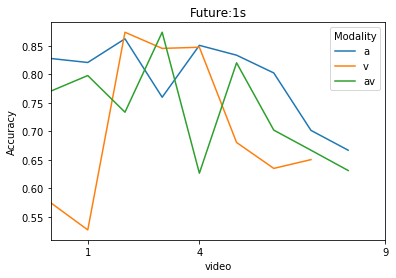

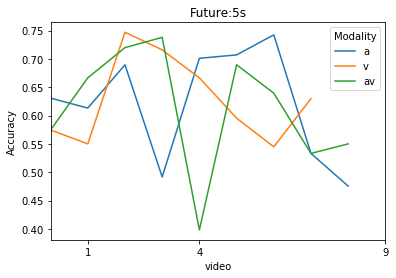

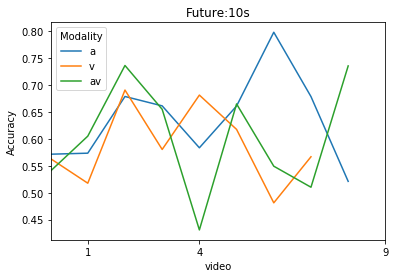

In [370]:

for future in [1, 5, 10]:
    plt.figure()
    for modality in ['a', 'v', 'av']:
        tmpdf = results[(results['future'] == future) & (results['modality'] == modality)].groupby(['video']).mean()['acc']
        tmpdf = tmpdf.reindex([x for i, x in enumerate(videos) if i %3 == 0],).dropna()
        tmpdf.plot(label=modality)
    plt.legend(title='Modality')
    plt.title('Future:' + str(future) + 's')
    plt.ylabel('Accuracy')
    plt.xticks([1, len(tmpdf) // 2, len(tmpdf)], [1, len(tmpdf) // 2, len(tmpdf)])
    plt.show()


In [303]:
results.groupby(['rater', 'future']).mean()['acc']

rater   future
cindy   1         0.745349
        5         0.633463
        10        0.635997
curtis  1         0.763438
        5         0.691912
        10        0.649404
lisa    1         0.727048
        5         0.534807
        10        0.543473
Name: acc, dtype: float64

In [32]:
results.groupby(['modality', 'future']).mean()['acc'].round(2)

modality  future
a         1         0.79
          5         0.62
          10        0.64
av        1         0.74
          5         0.61
          10        0.60
v         1         0.70
          5         0.63
          10        0.59
Name: acc, dtype: float64

In [110]:
results.groupby('rater')['acc'].agg(['mean', 'std'])

,mean,std
rater,,
cindy,0.606218,0.140451
curtis,0.636848,0.094176
erika,0.562401,0.118217


# Making figure for paper

In [20]:
df.T['acc', 'mean']

future   modality
1        a           0.79
         av          0.74
         v           0.72
5        a           0.69
         av          0.68
         v           0.67
10       a           0.69
         av          0.68
         v           0.59
average              0.69
Name: (acc, mean), dtype: float64

In [21]:
df.T['acc', 'std']

future   modality
1        a           0.08
         av          0.11
         v           0.14
5        a           0.11
         av          0.11
         v           0.08
10       a           0.11
         av          0.10
         v           0.04
average              0.10
Name: (acc, std), dtype: float64

In [41]:
# # 5 second history
# ml_results = {
#     'v' : [0.65, 0.65, 0.65],
#     'a' : [0.72, 0.65, 0.65],
#     'av' : [0.71, 0.65, 0.65],   
# }

# 5 second history (with prior because humans also use the prior)
ml_results = {
    'v' : [0.73, 0.65, 0.65],
    'a' : [0.75, 0.65, 0.65],
    'av' : [0.75, 0.66, 0.65],   
} 

# # 5 second history -- uses logreg
# old_lr_ml_results = {
#     'v' : [0.67, 0.65, 0.65],
#     'a' : [0.72, 0.69, 0.67],
#     'av' : [0.71, 0.69, 0.67],   
# }

# # 10 second history
# ml_results = {
#     'v' : [0.65, 0.65, 0.65],
#     'a' : [0.71, 0.69, 0.67],
#     'av' : [0.71, 0.68, 0.67],   
# }

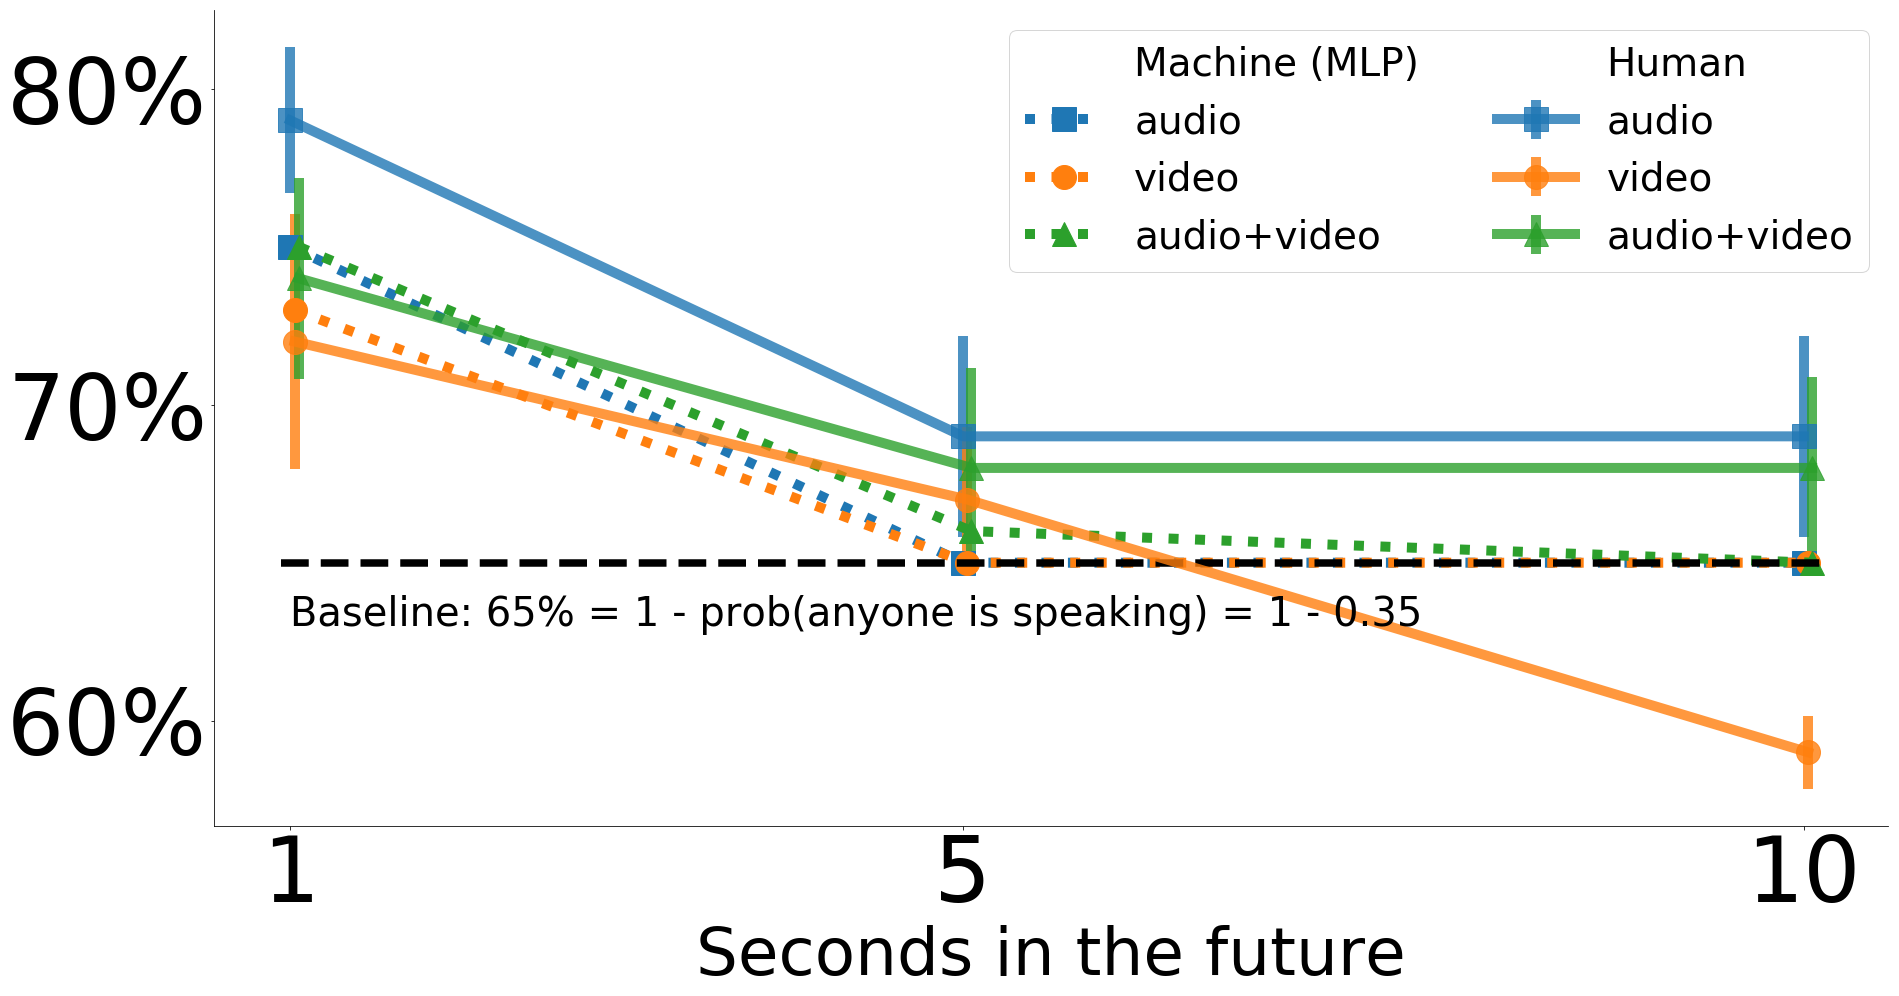

In [42]:

savefig = True
fontsize = 30

# Make sure fontsize is set
matplotlib.rcParams.update({'font.size': 3*fontsize})
plt.figure(figsize=(fontsize,fontsize/2))

# Create legend labels.
plt.plot([],marker="", ls="", label='Machine (MLP)')
plt.errorbar([],[],marker="", ls="", label='Human')
plt.gca().set_prop_cycle(None)

# Create markers.
markers = ['s', 'o', '^']

for i, modality in enumerate(['a','v','av']):
    if modality == 'av':
        name = 'audio+video'
    else:
        name = 'audio' if modality == 'a' else 'video'
    x = np.array([1,5,10]) + 0.025 * i
    y = df.T['acc', 'mean'].reset_index()[df.T['acc', 'mean'].reset_index()['modality'] == modality]['acc', 'mean']
    std = df.T['acc', 'std'].reset_index()[df.T['acc', 'std'].reset_index()['modality'] == modality]['acc', 'std'] / 2 / np.sqrt(3)
    p = plt.plot(x, ml_results[modality], marker=markers[i], 
        markersize=fontsize*0.8, linestyle=':',
        linewidth=fontsize / 3,label=name, alpha = 1)
    color = p[0].get_color()
    plt.errorbar(x, y, yerr=std, marker=markers[i], markersize=fontsize*0.8, 
        linewidth=fontsize / 3,label=name, alpha = 0.8, color=color)
plt.ylabel('')
plt.xticks([1,5,10])
plt.yticks([0.6, 0.7, 0.8])

ax = plt.gca()
        
# Format y-axis values
ax.set_yticklabels([str(int(round(z*100, 0)))+"%" for z in ax.get_yticks()])

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

legend_title = ''# 'Modality'
legend = plt.legend(title=legend_title, fontsize=1.3*fontsize, ncol=2, loc=1)

plt.axhline(1 - 0.35, xmin=.04, xmax=.96, color='black', ls='--', linewidth = fontsize/4)
plt.text(1,1 - 0.35 - 0.02,'Baseline: 65% = 1 - prob(anyone is speaking) = 1 - 0.35', fontsize=40)

# plt.axhline(0.5, xmin=.04, xmax=.96, color='black', ls='--', linewidth = fontsize/4)
# plt.text(1,0.51,'Random guessing', fontsize=40)

# plt.axhline(1 - 0.48, xmin=.04, xmax=.96, color='red', linestyle='--', linewidth = fontsize/4)
# plt.text(0.8,1 - 0.48 + 0.02,'1 - prob(host is speaking) = 1 - 0.48', fontsize=40)

# Make legend fontsize larger
_ = plt.setp(legend.get_title(),fontsize=2*fontsize)

_ = plt.xlabel("Seconds in the future", fontsize = 2.2*fontsize )
# _ = plt.title("Comparison of Machine vs. Human Baselines", fontsize = 2.2*fontsize )
    
if savefig:
    plt.savefig("test_set_human_predictions.pdf", dpi=600, pad_inches=0, bbox_inches = 'tight')
plt.show()


In [338]:
results.head()

,acc,file,modality,video
0,0.700000,egocom_human_predictions_cindy2.csv,a01,vid_173__day_6__con_6__person_1
1,0.550000,egocom_human_predictions_cindy2.csv,a05,vid_173__day_6__con_6__person_1
2,0.616667,egocom_human_predictions_cindy2.csv,a10,vid_173__day_6__con_6__person_1
3,0.759259,egocom_human_predictions_cindy2.csv,v01,vid_063__day_1__con_5__person_2_part4
4,0.773585,egocom_human_predictions_cindy2.csv,v05,vid_063__day_1__con_5__person_2_part4


In [ ]:
# In a small-scale human validation experiment, two human reviewers analyzed 5 minute segments across six videos. 
# The human reviewers. 
# Each video was reviewed once for only one modality to mitigate multiple exposure bias.

